In [1]:
#Final code of the project to detect damaged tissues on the lung

In [2]:
#importing libraries as needed
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import warnings
warnings.filterwarnings('ignore')
from PIL import Image 
from PIL.ImageDraw import Draw

#from keras.models import load_model
#import keras
#from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[]

In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2905015848177704328
 xla_global_id: -1]

In [5]:
#read in csv files
csv_path = 'csv_files/'
df_image_id = pd.read_csv(csv_path + 'nih-cxr-lt_image_ids.csv')
df_label_train = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_train.csv')
df_label_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_test.csv')
df_balanced_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-test.csv')
df_balanced_val = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-val.csv')
#there are 5 files:
#all image ids
#balanced testing dataset
#balanced validation dataset
#normal testing dataset
#normal training dataset

#fixing naming convention of a columns
df_label_train.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_train.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_train.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_train.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_label_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_val.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_val.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)

#create new dataframes that contain solely heart issues
#include columns only with heart related labels
#remove rows where all values are zero (no finding == 0 -> condition)
#cant do one liner for dropping so have to use conditional drop
df_label_train_heart = df_label_train[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_train_heart = df_label_train_heart.drop(df_label_train_heart[(df_label_train_heart.Cardiomegaly == 0) & (df_label_train_heart.Infiltration == 0) & (df_label_train_heart.Mass == 0) & (df_label_train_heart.Nodule == 0) & (df_label_train_heart.Tortuous_Aorta == 0) & (df_label_train_heart.Calcification_of_the_Aorta == 0) & (df_label_train_heart.No_Finding == 0) ].index)
df_label_test_heart = df_label_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_test_heart = df_label_test_heart.drop(df_label_test_heart[(df_label_test_heart.Cardiomegaly == 0) & (df_label_test_heart.Infiltration == 0) & (df_label_test_heart.Mass == 0) & (df_label_test_heart.Nodule == 0) & (df_label_test_heart.Tortuous_Aorta == 0) & (df_label_test_heart.Calcification_of_the_Aorta == 0) & (df_label_test_heart.No_Finding == 0) ].index)
df_balanced_test_heart = df_balanced_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_test_heart = df_balanced_test_heart.drop(df_balanced_test_heart[(df_balanced_test_heart.Cardiomegaly == 0) & (df_balanced_test_heart.Infiltration == 0) & (df_balanced_test_heart.Mass == 0) & (df_balanced_test_heart.Nodule == 0) & (df_balanced_test_heart.Tortuous_Aorta == 0) & (df_balanced_test_heart.Calcification_of_the_Aorta == 0) & (df_balanced_test_heart.No_Finding == 0) ].index)
df_balanced_val_heart = df_balanced_val[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_val_heart = df_balanced_val_heart.drop(df_balanced_val_heart[(df_balanced_val_heart.Cardiomegaly == 0) & (df_balanced_val_heart.Infiltration == 0) & (df_balanced_val_heart.Mass == 0) & (df_balanced_val_heart.Nodule == 0) & (df_balanced_val_heart.Tortuous_Aorta == 0) & (df_balanced_val_heart.Calcification_of_the_Aorta == 0) & (df_balanced_val_heart.No_Finding == 0) ].index)
display(df_label_train_heart)

# #create new dataframes that contain solely lung issues (what we are currently concerned with)
# #include columns only with lung related labels
# #remove rows where all values are zero
df_label_train_lung = df_label_train[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[(df_label_train_lung.Atelectasis == 0) & (df_label_train_lung.Consolidation == 0) & (df_label_train_lung.Edema == 0) & (df_label_train_lung.Effusion == 0) & (df_label_train_lung.Emphysema == 0) & (df_label_train_lung.Fibrosis == 0) & (df_label_train_lung.Hernia == 0) & (df_label_train_lung.Infiltration == 0) & (df_label_train_lung.Mass == 0) & (df_label_train_lung.Nodule == 0) & (df_label_train_lung.Pleural_Thickening == 0) & (df_label_train_lung.Pneumonia == 0) & (df_label_train_lung.Pneumothorax == 0)& (df_label_train_lung.Pneumomediastinum == 0) & (df_label_train_lung.No_Finding == 0)].index)
df_label_test_lung = df_label_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[(df_label_test_lung.Atelectasis == 0) & (df_label_test_lung.Consolidation == 0) & (df_label_test_lung.Edema == 0) & (df_label_test_lung.Effusion == 0) & (df_label_test_lung.Emphysema == 0) & (df_label_test_lung.Fibrosis == 0) & (df_label_test_lung.Hernia == 0) & (df_label_test_lung.Infiltration == 0) & (df_label_test_lung.Mass == 0) & (df_label_test_lung.Nodule == 0) & (df_label_test_lung.Pleural_Thickening == 0) & (df_label_test_lung.Pneumonia == 0) & (df_label_test_lung.Pneumothorax == 0)& (df_label_test_lung.Pneumomediastinum == 0) & (df_label_test_lung.No_Finding == 0)].index)
df_balanced_test_lung = df_balanced_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[(df_balanced_test_lung.Atelectasis == 0) & (df_balanced_test_lung.Consolidation == 0) & (df_balanced_test_lung.Edema == 0) & (df_balanced_test_lung.Effusion == 0) & (df_balanced_test_lung.Emphysema == 0) & (df_balanced_test_lung.Fibrosis == 0) & (df_balanced_test_lung.Hernia == 0) & (df_balanced_test_lung.Infiltration == 0) & (df_balanced_test_lung.Mass == 0) & (df_balanced_test_lung.Nodule == 0) & (df_balanced_test_lung.Pleural_Thickening == 0) & (df_balanced_test_lung.Pneumonia == 0) & (df_balanced_test_lung.Pneumothorax == 0) & (df_balanced_test_lung.Pneumomediastinum == 0) & (df_balanced_test_lung.No_Finding == 0)].index)
df_balanced_val_lung = df_balanced_val[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[(df_balanced_val_lung.Atelectasis == 0) & (df_balanced_val_lung.Consolidation == 0) & (df_balanced_val_lung.Edema == 0) & (df_balanced_val_lung.Effusion == 0) & (df_balanced_val_lung.Emphysema == 0) & (df_balanced_val_lung.Fibrosis == 0) & (df_balanced_val_lung.Hernia == 0) & (df_balanced_val_lung.Infiltration == 0) & (df_balanced_val_lung.Mass == 0) & (df_balanced_val_lung.Nodule == 0) & (df_balanced_val_lung.Pleural_Thickening == 0) & (df_balanced_val_lung.Pneumonia == 0) & (df_balanced_val_lung.Pneumothorax == 0) & (df_balanced_val_lung.Pneumomediastinum == 0) & (df_balanced_val_lung.No_Finding == 0)].index)
display(df_label_train_lung)

#saving new dataframes
df_label_train_heart.to_csv(csv_path + 'label_train_heart.csv', index=False)
df_label_test_heart.to_csv(csv_path + 'label_test_heart.csv', index=False)
df_balanced_test_heart.to_csv(csv_path + 'balanced_test_heart.csv', index=False)
df_balanced_val_heart.to_csv(csv_path + 'balanced_val_heart.csv', index=False)
df_label_train_lung.to_csv(csv_path + 'label_train_lung.csv', index=False)
df_label_test_lung.to_csv(csv_path + 'label_test_lung.csv', index=False)
df_balanced_test_lung.to_csv(csv_path + 'balanced_test_lung.csv', index=False)
df_balanced_val_lung.to_csv(csv_path + 'balanced_val_lung.csv', index=False)

,id,Cardiomegaly,Infiltration,Mass,Nodule,Tortuous_Aorta,Calcification_of_the_Aorta,No_Finding,subject_id
0,00000001_000.png,1,0,0,0,0,0,0,1
1,00000002_000.png,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,1,30804


,id,Atelectasis,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumomediastinum,No_Finding,subject_id
1,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
5,00000005_003.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30804


In [6]:
#selecting wanted data values for predicting lung cancer (id, Mass, Nodule, No_Finding)
cancer_train = df_label_train_lung[(df_label_train_lung.Nodule == 1) | (df_label_train_lung.Mass == 1)] 
cancer_train_neg = df_label_train_lung[(df_label_train_lung.No_Finding == 1)]
cancer_val = df_balanced_val_lung[(df_balanced_val_lung.Nodule == 1) | (df_balanced_val_lung.Mass == 1)]
cancer_val_neg = df_balanced_val_lung[(df_balanced_val_lung.No_Finding == 1)]
cancer_test = df_label_test_lung[(df_label_test_lung.Nodule == 1) | (df_label_test_lung.Mass == 1)]
cancer_test_neg = df_label_test_lung[(df_label_test_lung.No_Finding == 1)]
#selecting only relevant columns 
cancer_train = cancer_train[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_train_neg = cancer_train_neg[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_val = cancer_val[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_val_neg = cancer_val_neg[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_test = cancer_test[['id', 'Mass', 'Nodule', 'No_Finding']]
cancer_test_neg = cancer_test_neg[['id', 'Mass', 'Nodule', 'No_Finding']]

In [7]:
#select range from each and append, then shuffle
train_add = cancer_train_neg[0:3701]
cancer_train = cancer_train.append(train_add)
cancer_train = cancer_train.sample(frac = 1)
val_add = cancer_val_neg[0:14]
cancer_val = cancer_val.append(val_add)
cancer_val = cancer_val.sample(frac = 1)
test_add = cancer_test_neg[0:1000]
cancer_test = cancer_test.append(test_add)
cancer_test = cancer_test.sample(frac = 1)

In [8]:
#consolidating the data and one hot encoding
conditions = [(cancer_train['No_Finding']==1),
              (cancer_train['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_train['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_train['target'])
cancer_train = cancer_train.join(encoded)
cancer_train = cancer_train.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_train.rename(columns = {cancer_train.columns[1]:'cancer_negative', cancer_train.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_train)

,id,cancer_negative,cancer_positive
1866,00000869_006.png,1,0
3716,00001712_000.png,1,0
59002,00025635_005.png,0,1
18753,00007691_004.png,0,1
34891,00013911_016.png,0,1
...,...,...,...
67212,00030159_007.png,0,1
2181,00001040_000.png,0,1
4643,00002048_005.png,1,0
18864,00007731_005.png,0,1


In [9]:
conditions = [(cancer_val['No_Finding']==1),
              (cancer_val['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_val['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_val['target'])
cancer_val = cancer_val.join(encoded)
cancer_val = cancer_val.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_val.rename(columns = {cancer_val.columns[1]:'cancer_negative', cancer_val.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_val)
len(cancer_val)

,id,cancer_negative,cancer_positive
143,00015196_010.png,0,1
286,00004425_001.png,1,0
293,00013138_002.png,1,0
160,00010872_002.png,0,1
158,00007454_003.png,0,1
157,00007454_002.png,0,1
296,00029025_002.png,1,0
154,00004436_004.png,0,1
136,00004532_002.png,0,1
145,00018101_006.png,0,1


44

In [10]:
conditions = [(cancer_test['No_Finding']==1),
              (cancer_test['No_Finding']==0)
             ]

values = [0, 1]
              
cancer_test['target'] = np.select(conditions, values)

encoded = pd.get_dummies(cancer_test['target'])
cancer_test = cancer_test.join(encoded)
cancer_test = cancer_test.drop(['Mass', 'Nodule', 'No_Finding', 'target'], axis=1)
cancer_test.rename(columns = {cancer_test.columns[1]:'cancer_negative', cancer_test.columns[2]:'cancer_positive'}, inplace = True)
display(cancer_test)
len(cancer_test)

,id,cancer_negative,cancer_positive
308,00000399_001.png,1,0
1795,00002361_013.png,0,1
11022,00015029_000.png,0,1
3858,00005014_008.png,0,1
681,00000832_003.png,1,0
...,...,...,...
1422,00001762_003.png,1,0
978,00001194_003.png,1,0
4063,00005218_015.png,0,1
1338,00001690_002.png,1,0


1969

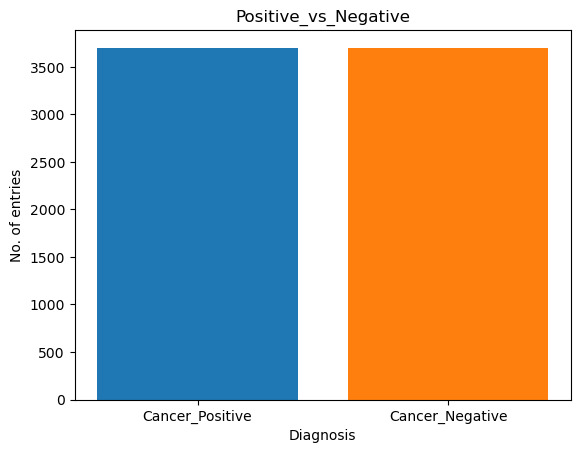

In [11]:
#plot of data
cancer_positive = len(cancer_train[cancer_train['cancer_negative'] == 0].index)
cancer_negative = len(cancer_train[cancer_train['cancer_negative'] == 1].index)

plt.bar('Cancer_Positive' ,cancer_positive, label= 'Positive')
plt.bar('Cancer_Negative' ,cancer_negative, label = 'Negative')
plt.xlabel("Diagnosis")
plt.ylabel("No. of entries")
plt.title("Positive_vs_Negative")
plt.show()

In [12]:
#add pathing to front of images in csv (chest_xrays/)
cancer_train['id'] = 'chest_xrays/' + cancer_train['id'].astype(str)
cancer_val['id'] = 'chest_xrays/' + cancer_val['id'].astype(str)
cancer_test['id'] = 'chest_xrays/' + cancer_test['id'].astype(str)

In [13]:
#adding entries from train to validation due to lack of entries
#adjust values
val_add = cancer_train[7000:7402]
cancer_train = cancer_train[0:7000]
cancer_val = cancer_val.append(val_add)
display(cancer_train)
display(cancer_val)
display(cancer_test)

,id,cancer_negative,cancer_positive
1866,chest_xrays/00000869_006.png,1,0
3716,chest_xrays/00001712_000.png,1,0
59002,chest_xrays/00025635_005.png,0,1
18753,chest_xrays/00007691_004.png,0,1
34891,chest_xrays/00013911_016.png,0,1
...,...,...,...
46872,chest_xrays/00018751_000.png,0,1
1737,chest_xrays/00000808_005.png,1,0
54578,chest_xrays/00022444_001.png,0,1
39162,chest_xrays/00015556_021.png,0,1


,id,cancer_negative,cancer_positive
143,chest_xrays/00015196_010.png,0,1
286,chest_xrays/00004425_001.png,1,0
293,chest_xrays/00013138_002.png,1,0
160,chest_xrays/00010872_002.png,0,1
158,chest_xrays/00007454_003.png,0,1
...,...,...,...
67212,chest_xrays/00030159_007.png,0,1
2181,chest_xrays/00001040_000.png,0,1
4643,chest_xrays/00002048_005.png,1,0
18864,chest_xrays/00007731_005.png,0,1


,id,cancer_negative,cancer_positive
308,chest_xrays/00000399_001.png,1,0
1795,chest_xrays/00002361_013.png,0,1
11022,chest_xrays/00015029_000.png,0,1
3858,chest_xrays/00005014_008.png,0,1
681,chest_xrays/00000832_003.png,1,0
...,...,...,...
1422,chest_xrays/00001762_003.png,1,0
978,chest_xrays/00001194_003.png,1,0
4063,chest_xrays/00005218_015.png,0,1
1338,chest_xrays/00001690_002.png,1,0


In [14]:
columns = ['cancer_negative', 'cancer_positive'] 

In [15]:
#preprocessing and splitting of train and test data
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)
#preprocessing of training images
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=cancer_train,
                                                   x_col="id",
                                                   y_col=columns, #can add more categories here
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=50,
                                                   subset="training")

Found 6300 validated image filenames.


In [16]:
Validation_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)
#preprocessing of validation images
Validation_IMG_Set = Validation_Generator.flow_from_dataframe(dataframe=cancer_val,
                                                   x_col="id",
                                                   y_col=columns,
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=100,
                                                   subset="validation")

Found 44 validated image filenames.


In [17]:
Test_Generator = ImageDataGenerator(rescale=1./255)
#preprocessing of testing images
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=cancer_test,
                                                 x_col="id",
                                                 y_col=columns,
                                                 color_mode="rgb",
                                                 class_mode="raw",
                                                 batch_size=100)

Found 1969 validated image filenames.


In [18]:
import keras,os
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.layers import Dense, Activation, Dropout, GlobalMaxPooling2D

from tensorflow.keras.applications.resnet import ResNet152

In [19]:
input_shape = (256,256,3)

model = Sequential()
model.add(ResNet152(input_shape=(256, 256, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 8, 8, 2048)        58370944  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 58,375,042
Trainable params: 58,223,618
Non-trainable params: 151,424
_________________________________________________________________


In [22]:
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
hist = model.fit(Train_IMG_Set, validation_data= Validation_IMG_Set, epochs=40)

Epoch 1/40
126/126 [==============================] - 5227s 41s/step - loss: 1.1265 - accuracy: 0.4914 - val_loss: 10693.5166 - val_accuracy: 0.3182
Epoch 2/40
126/126 [==============================] - 5219s 41s/step - loss: 0.9127 - accuracy: 0.4903 - val_loss: 119.7127 - val_accuracy: 0.4318
Epoch 3/40
126/126 [==============================] - 5199s 41s/step - loss: 0.9396 - accuracy: 0.4995 - val_loss: 3944.9031 - val_accuracy: 0.3182
Epoch 4/40
126/126 [==============================] - 5188s 41s/step - loss: 0.8791 - accuracy: 0.5003 - val_loss: 67.7278 - val_accuracy: 0.6818
Epoch 5/40
126/126 [==============================] - 5182s 41s/step - loss: 0.8577 - accuracy: 0.5017 - val_loss: 0.6300 - val_accuracy: 0.6818
Epoch 6/40
126/126 [==============================] - 5175s 41s/step - loss: 0.8890 - accuracy: 0.4929 - val_loss: 1.6703 - val_accuracy: 0.7045
Epoch 7/40
126/126 [==============================] - 5184s 41s/step - loss: 0.8640 - accuracy: 0.5073 - val_loss: 0.865

In [24]:
model.save('resnet152_fit.h5')
from keras.models import load_model
model = load_model("resnet152_fit.h5")

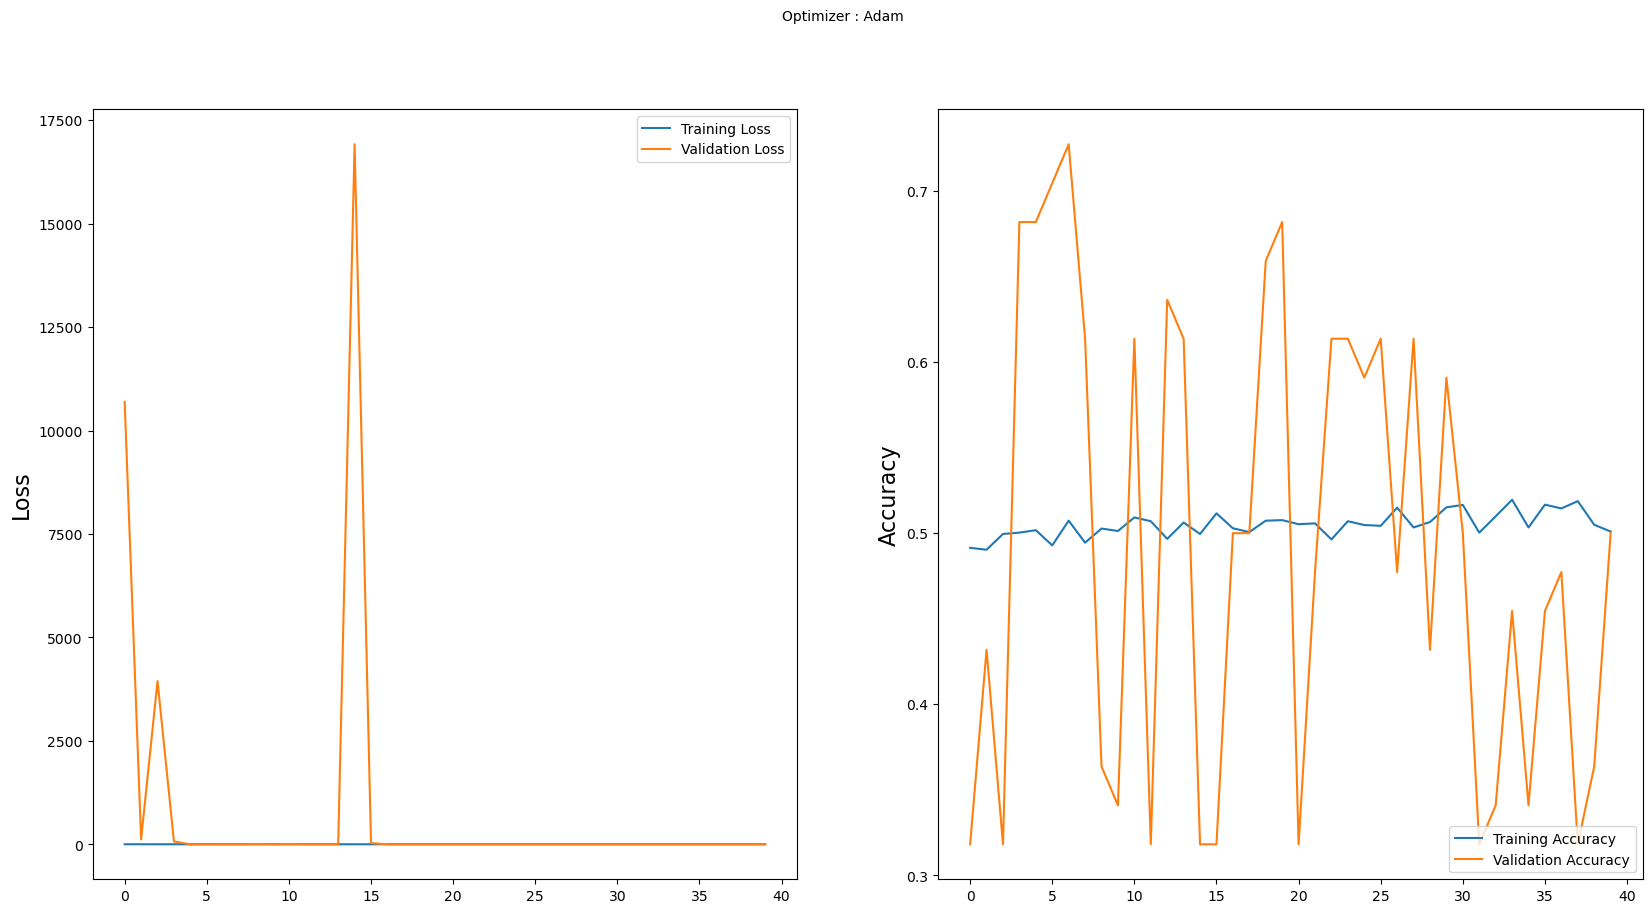

In [25]:
#plotting accuracy and loss
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [26]:
#validation
results_val = model.evaluate(Validation_IMG_Set)
preds_val   = model.predict(Validation_IMG_Set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results_val[1]*100,2)))

1/1 [==============================] - 19s 19s/step
The current model achieved a categorical accuracy of 52.27%!


In [27]:
#testing results
results = model.evaluate(Test_IMG_Set)
preds   = model.predict(Test_IMG_Set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

20/20 [==============================] - 373s 18s/step
The current model achieved a categorical accuracy of 48.4%!


In [28]:
#storing test predictions
Prediction_One = model.predict(Test_IMG_Set)
Prediction_One = Prediction_One.argmax(axis=-1)
Predict_Class = np.argmax(model.predict(Test_IMG_Set),axis=1)

20/20 [==============================] - 373s 18s/step


In [29]:
import math
test_batches = Test_Generator.flow_from_dataframe(dataframe = cancer_test, x_col="id", y_col="cancer_positive", class_mode="raw", batch_size=100)
number_of_examples = len(Test_IMG_Set.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 100)) 
# 1.0 above is to skip integer division

For_Prediction_Class = []

for i in range(0,int(number_of_generator_calls)):
    For_Prediction_Class.extend(np.array(test_batches[i][1]))

Found 1969 validated image filenames.


In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve

In [31]:
#confusion matrix and other metrics
print(confusion_matrix(For_Prediction_Class,Predict_Class))
print(classification_report(For_Prediction_Class,Predict_Class))

[[160 840]
 [148 821]]
              precision    recall  f1-score   support

           0       0.52      0.16      0.24      1000
           1       0.49      0.85      0.62       969

    accuracy                           0.50      1969
   macro avg       0.51      0.50      0.43      1969
weighted avg       0.51      0.50      0.43      1969

